## Time to get your hands dirty. Galaxies vs quasars with neural networks.

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the [multilayer perceptron classifier](sklearn.neural_network.MLPClassifier) implemented in scikit-learn. My solution uses the latter, but this is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do your best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?


A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use `GridSearchCV` already. For Tensorflow, there's a really cool tool called [Tensorboard](https://www.tensorflow.org/tensorboard)

In [13]:
import emcee
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from astropy.table import Table

from astroML.utils import completeness_contamination
from astroML.utils.decorators import pickle_results
from astroML.utils import split_samples
from astroML.classification import GMMBayes

from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn import preprocessing
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import GridSearchCV

# Data fetching

In [14]:
filename = "../solutions/galaxyquasar.csv"
table = Table.read(filename)

In [15]:
u_g = table["u"] - table["g"]
g_r = table["g"] - table["r"]
r_i = table["r"] - table["i"]
i_z = table["i"] - table["z"]

labels = table["class"]

In [16]:
labels_z_o = np.where(labels=="QSO", 1, 0)

In [17]:
N_dim_dataset = np.array([u_g, g_r, r_i, i_z]).T

In [18]:
X_train, X_test, y_train, y_test = train_test_split(N_dim_dataset, labels_z_o, test_size=0.3, random_state=1) 

Quick overview of the dataset:

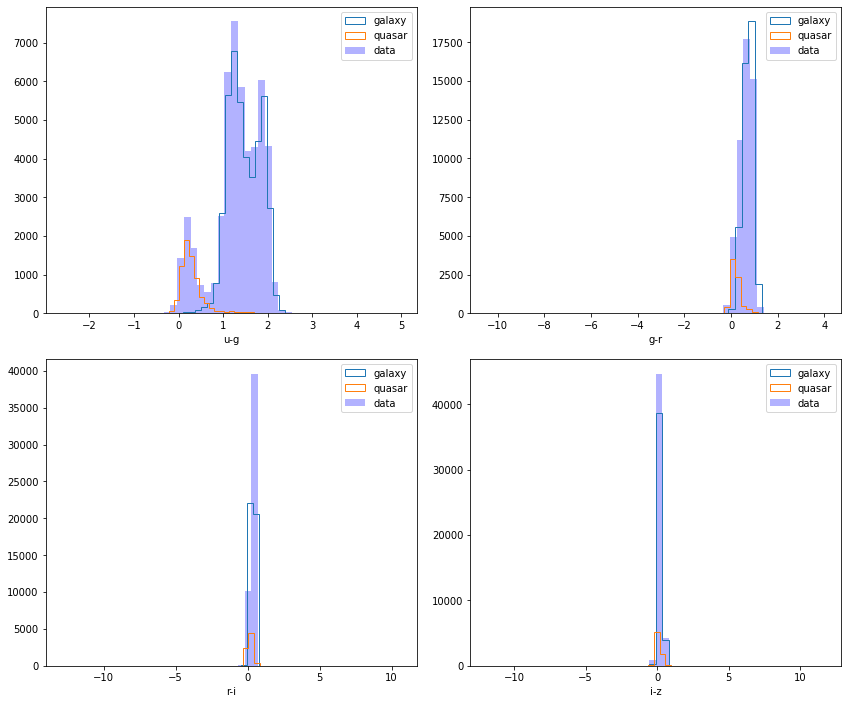

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

labels=["u-g", "g-r", "r-i", "i-z"]

for ax, data, xlabel in zip(axs.flatten(), N_dim_dataset.T, labels):
    
    ax.hist(data[labels_z_o==0], bins=50, histtype = 'step', label = 'galaxy', lw=1)
    ax.hist(data[labels_z_o==1], bins=50, histtype = 'step', label = 'quasar', lw=1)
    ax.hist(data, bins=50, label = 'data', color='blue', alpha=0.3)
    ax.legend()
    ax.set_xlabel(xlabel)
    
plt.tight_layout(pad=1.5);

I scale the quantities such that your neural network works with the same quantities. This is essential as a passage because it helps with magnitude issues:

In [20]:
Xtrain_scaled = preprocessing.scale(X_train)
Xtest_scaled = preprocessing.scale(X_test)
X_scaled = preprocessing.scale(N_dim_dataset)

# Classifying via NN

I chose the sklearn MPL classifier, because I am more used to the synthax of the package to call out the different quantities I need.

## MPL Classifier

- N-dimensional analysis

In [21]:
clf = MLPClassifier(solver='adam', alpha=1e-5, 
                   hidden_layer_sizes=(5), 
                   random_state=1, max_iter=5000, learning_rate='constant', activation='relu')  # default lr for adam solver is already 0.001

clf.fit(Xtrain_scaled, y_train)

print([coef.shape for coef in clf.coefs_])  # looking at the weights 

y_pred = clf.predict(Xtest_scaled)

[(4, 5), (5, 1)]


Visualize classification on the different components:

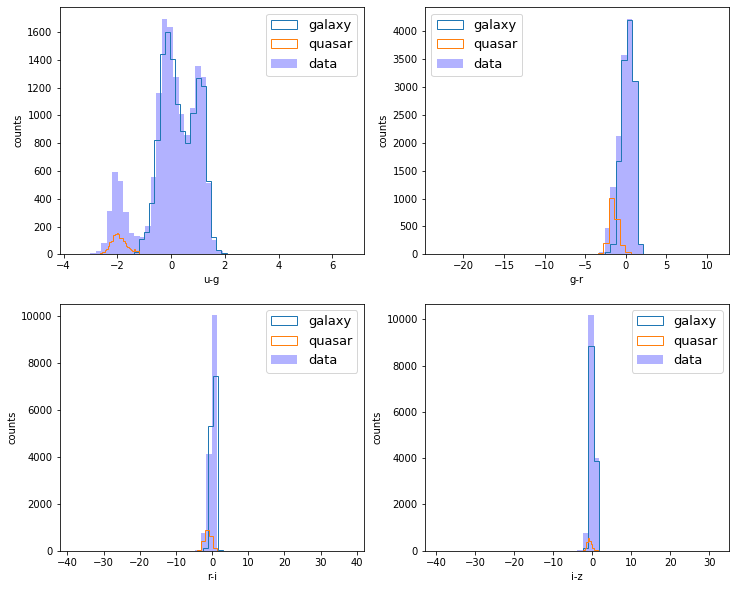

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for ax, xlabel, i in zip(axs.flatten(), labels, range(0, 4)):
    
    ax.hist(Xtest_scaled[:, i][y_pred==0], bins=50, histtype = 'step', label = 'galaxy', lw=1)
    ax.hist(Xtest_scaled[:, i][y_pred==1], bins=50, histtype = 'step', label = 'quasar', lw=1)
    ax.hist(Xtest_scaled[:, i], bins=50, label = 'data', color='blue', alpha=0.3)
    ax.set_ylabel('counts')
    ax.set_xlabel(xlabel)
    ax.legend(fontsize=13)
    
plt.show()

### ROC curve

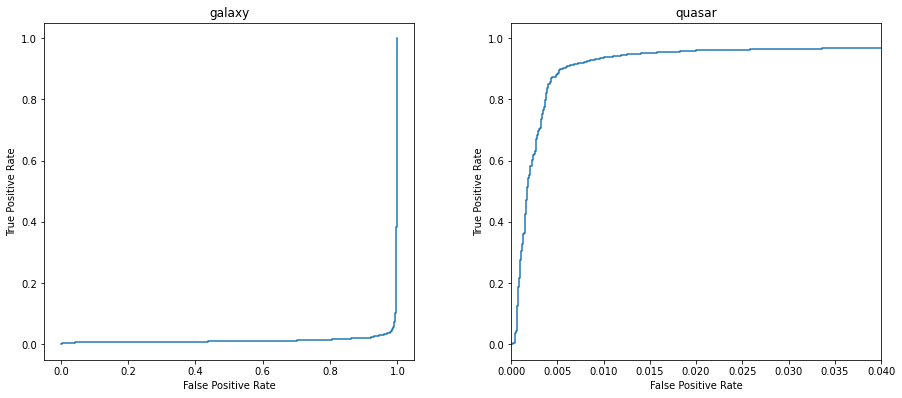

In [23]:
y_score = [clf.predict_proba(Xtest_scaled)[:, 0], clf.predict_proba(Xtest_scaled)[:, 1]]

det_und = ["galaxy", "quasar"]


fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for i in range(0, 2):
    
    fpr, tpr, _ = roc_curve(y_test, y_score[i], pos_label=None, sample_weight=None, drop_intermediate=True)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[i])
    
    axs[i].set_title(det_und[i])
    axs[i].set_xlabel("False Positive Rate")
    axs[i].set_ylabel("True Positive Rate")
    
axs[1].set_xlim(0, 0.04)  # the one used in the notebook

    
plt.tight_layout(pad=6.0)  # spacing between subplots

plt.show()

### Optimizing the classifier

In this section I chose to optimize the classifier using GridSearchCV. I set the parameters trying to explore different orders of magnitude, and layer sizes.  

In [24]:
mlpc = MLPClassifier(max_iter=10000)  # keep max_iter low to avoid crash

parameter_space = {
    'hidden_layer_sizes': [(5,),(10,), (5,5)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.002, 0.05],
    'learning_rate': ['constant','adaptive'],
}


clf = GridSearchCV(mlpc, parameter_space, n_jobs=-1, cv=4)

clf.fit(Xtrain_scaled, y_train) 

GridSearchCV(cv=4, estimator=MLPClassifier(max_iter=10000), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.002, 0.05],
                         'hidden_layer_sizes': [(5,), (10,), (5, 5)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [25]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive', 'solver': 'adam'}


## Accuracy:

In [26]:
def accuracy(confusion_matrix):
        
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
        
    return diagonal_sum / sum_of_all_elements

In [27]:
cm = confusion_matrix(y_pred, y_test)

In [28]:
print("Accuracy of MLPClassifier:", accuracy(cm))
print("Confusion matrix:", cm)

Accuracy of MLPClassifier: 0.9818666666666667
Confusion matrix: [[12733   169]
 [  103  1995]]


It seems that using a neural network is getting better accuracy, even if by a 4%. I am finally trying to see if anything changes in the 1D analysis. 

# 1-dimensional analysis

In [29]:
X_train_1d, X_test_1d, y_train_1d, y_test_1d = train_test_split(u_g, labels_z_o, test_size=0.3, random_state=1) 

In [30]:
Xtrain_scaled_1d = preprocessing.scale(X_train_1d)
Xtest_scaled_1d = preprocessing.scale(X_test_1d)
X_scaled_1d = preprocessing.scale(u_g)

In [31]:
clf = MLPClassifier(solver='adam', alpha=1e-5, 
                   hidden_layer_sizes=(5), 
                   random_state=1, max_iter=5000, learning_rate='constant', activation='relu')  # default lr for adam solver is already 0.001

clf.fit(Xtrain_scaled_1d.reshape(-1, 1), y_train_1d)

print([coef.shape for coef in clf.coefs_])  # looking at the weights 

y_pred_1d = clf.predict(Xtest_scaled_1d.reshape(-1, 1))

[(1, 5), (5, 1)]


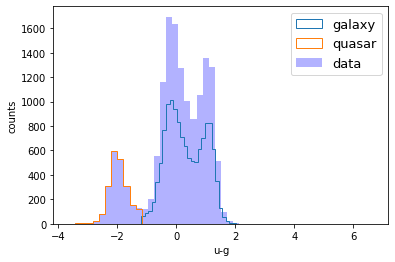

In [32]:
plt.hist(Xtest_scaled_1d[:][y_pred_1d==0], bins=50, histtype = 'step', label = 'galaxy', lw=1)
plt.hist(Xtest_scaled_1d[:][y_pred_1d==1], bins=50, histtype = 'step', label = 'quasar', lw=1)
plt.hist(Xtest_scaled_1d[:], bins=50, label = 'data', color='blue', alpha=0.3)
plt.ylabel('counts')
plt.xlabel('u-g')
plt.legend(fontsize=13)

## Accuracy

In [33]:
cm_1d = confusion_matrix(y_pred_1d, y_test_1d)

In [34]:
print("Accuracy of MLPClassifier:", accuracy(cm_1d))
print("Confusion matrix:", cm_1d)

Accuracy of MLPClassifier: 0.9811333333333333
Confusion matrix: [[12710   157]
 [  126  2007]]
